# 04 — Demand Forecasting & Operational Planning (Phase 5)

Phase 5 builds on prior exploratory and segmentation work by translating
observed demand patterns into forward-looking operational guidance.

The goal of this phase is **not** high-complexity prediction or machine learning.
Instead, the focus is on simple, interpretable forecasting techniques that help
answer practical business questions such as:

- What does a typical day look like?
- When should staffing be highest or lowest?
- Which hours represent underutilized demand?
- How do weekday and weekend expectations differ?

All forecasts in this phase are baseline expectations derived from historical
patterns, intended to support planning and decision-making rather than precise
prediction.

## Section 0 — Phase 5 Setup

### Load CLEANED Data (from disk)

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
q1 = pd.read_csv("../data/cleaned/orders_2025_q1.csv")
q2 = pd.read_csv("../data/cleaned/orders_2025_q2.csv")
q3 = pd.read_csv("../data/cleaned/orders_2025_q3.csv")
q4 = pd.read_csv("../data/cleaned/orders_2025_q4.csv")

In [6]:
q1.shape, q2.shape, q3.shape, q4.shape

((12122, 9), (11704, 9), (12882, 9), (13779, 9))

In [7]:
for df in [q1, q2, q3, q4]:
    df["Order Date"] = pd.to_datetime(df["Order Date"], utc=True)
    df["Order Date"] = df["Order Date"].dt.tz_convert("America/Los_Angeles")

In [8]:
q1["Order Date"].dtype

datetime64[ns, America/Los_Angeles]

### Concatenate All Quarters

In [9]:
orders_2025 = pd.concat([q1, q2, q3, q4], ignore_index=True)

In [10]:
orders_2025.shape

(50487, 9)

In [11]:
orders_2025["Order ID"].nunique()

50487

In [12]:
orders_2025["Order Date"].min(), orders_2025["Order Date"].max()

(Timestamp('2025-01-01 11:03:00-0800', tz='America/Los_Angeles'),
 Timestamp('2025-12-31 22:02:00-0800', tz='America/Los_Angeles'))

## Section 0 Summary

At this point, a single, time-normalized 2025 order-level dataset is available
for forecasting analysis.

Subsequent sections will aggregate this data into forecast-ready time series
representations, beginning with simple demand baselines by hour and day.

## Section 1 — Aggregate Demand for Forecasting

This section prepares forecast-ready demand series by aggregating orders
across time. The goal is to create simple, interpretable baselines that
describe expected demand by hour and by day.

### Create Time-Based Features

In [13]:
orders_2025["order_hour"] = orders_2025["Order Date"].dt.hour
orders_2025["order_dow"] = orders_2025["Order Date"].dt.day_name()
orders_2025["order_date"] = orders_2025["Order Date"].dt.date

In [14]:
orders_2025[["Order Date", "order_hour", "order_dow", "order_date"]].head()

,Order Date,order_hour,order_dow,order_date
0,2025-03-31 22:54:00-07:00,22,Monday,2025-03-31
1,2025-03-31 22:35:00-07:00,22,Monday,2025-03-31
2,2025-03-31 22:33:00-07:00,22,Monday,2025-03-31
3,2025-03-31 22:24:00-07:00,22,Monday,2025-03-31
4,2025-03-31 22:23:00-07:00,22,Monday,2025-03-31


### Aggregate Demand by Hour (All Days)

In [15]:
orders_by_hour = orders_2025.groupby("order_hour")["Order ID"].nunique()
orders_by_hour

order_hour
9        5
10     270
11    2543
12    2570
13    2900
14    3381
15    4266
16    5641
17    6443
18    6205
19    5375
20    4669
21    3683
22    2422
23     114
Name: Order ID, dtype: int64

### Visualize Average Hourly Demand

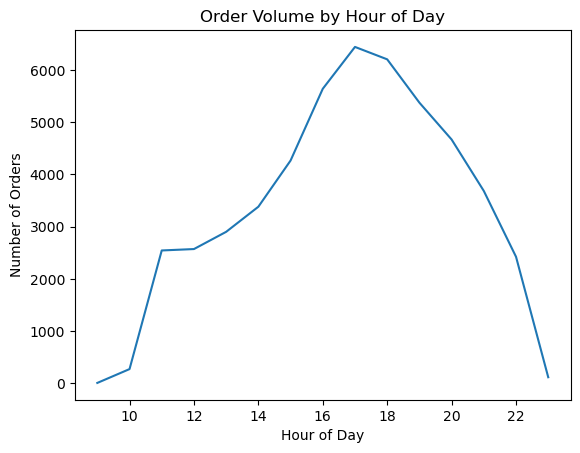

In [16]:
plt.figure()
orders_by_hour.plot(kind="line")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Orders")
plt.title("Order Volume by Hour of Day")
plt.show()

### Aggregate Demand by Day of Week

In [17]:
orders_by_dow = orders_2025.groupby("order_dow")["Order ID"].nunique()
orders_by_dow

order_dow
Friday       9234
Monday       5643
Saturday     8986
Sunday       8457
Thursday     6362
Tuesday      5518
Wednesday    6287
Name: Order ID, dtype: int64

In [18]:
day_order = [
    "Monday", "Tuesday", "Wednesday",
    "Thursday", "Friday", "Saturday", "Sunday"
]

In [19]:
orders_by_dow = orders_by_dow.reindex(day_order)
orders_by_dow

order_dow
Monday       5643
Tuesday      5518
Wednesday    6287
Thursday     6362
Friday       9234
Saturday     8986
Sunday       8457
Name: Order ID, dtype: int64

### Visualize Demand by Day of Week

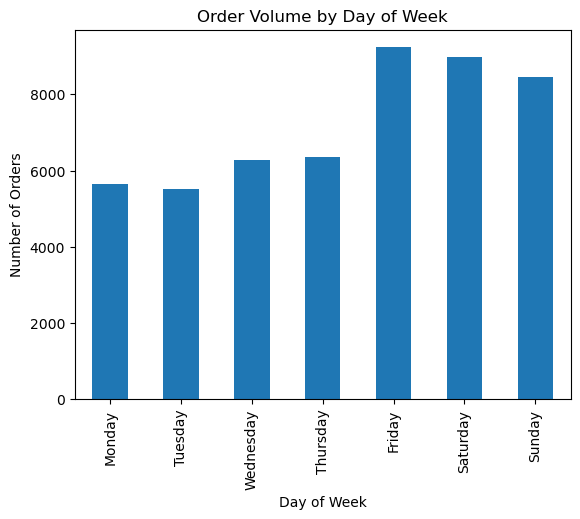

In [20]:
plt.figure()
orders_by_dow.plot(kind="bar")
plt.xlabel("Day of Week")
plt.ylabel("Number of Orders")
plt.title("Order Volume by Day of Week")
plt.show()

### Aggregate Daily Demand (Calendar Level)

In [21]:
orders_by_date = orders_2025.groupby("order_date")["Order ID"].nunique()
orders_by_date.head()

order_date
2025-01-01    163
2025-01-02    100
2025-01-03    165
2025-01-04    164
2025-01-05    163
Name: Order ID, dtype: int64

### Visualize Daily Demand Over Time

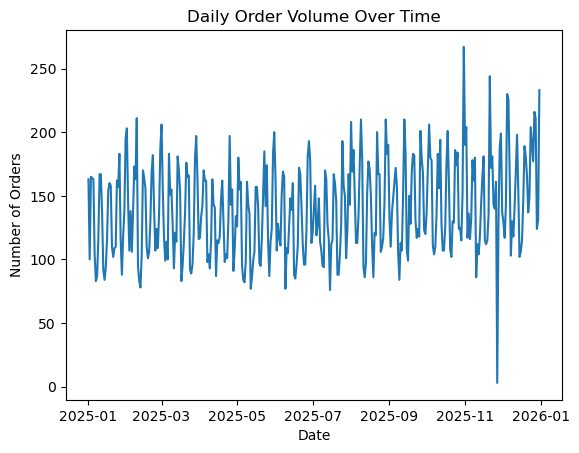

In [22]:
plt.figure()
orders_by_date.plot(kind="line")
plt.xlabel("Date")
plt.ylabel("Number of Orders")
plt.title("Daily Order Volume Over Time")
plt.show()

### Ensure Continuous Date Index (Fill Missing Days)

In [23]:
full_date_range = pd.date_range(
    start=orders_by_date.index.min(),
    end=orders_by_date.index.max(),
    freq="D"
)

In [24]:
orders_by_date_full = orders_by_date.reindex(full_date_range, fill_value=0)

In [25]:
orders_by_date_full.head()

2025-01-01    163
2025-01-02    100
2025-01-03    165
2025-01-04    164
2025-01-05    163
Freq: D, Name: Order ID, dtype: int64

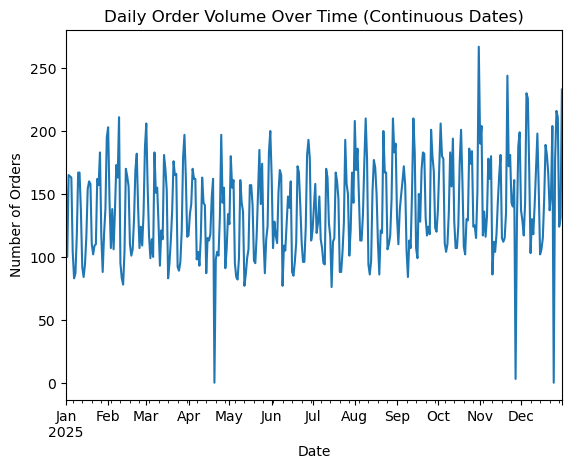

In [26]:
plt.figure()
orders_by_date_full.plot(kind="line")
plt.xlabel("Date")
plt.ylabel("Number of Orders")
plt.title("Daily Order Volume Over Time (Continuous Dates)")
plt.show()

Reindexing to a continuous date range reveals days with zero recorded orders,
which were omitted in the original aggregation. Preserving calendar continuity
is important for forecasting and operational planning, as it prevents misleading
gaps or slopes between non-consecutive dates.

## Section 1 Summary

Demand aggregation reveals strong and consistent time-based structure.
Hourly patterns show predictable peaks during late afternoon and evening
hours, while day-of-week patterns highlight elevated demand on weekends.

These aggregated series form the baseline expectation for demand and will
serve as the foundation for weekday vs weekend comparisons and simple
forecasting baselines in the next section.

## Section 2 — Weekday vs Weekend Demand Baselines

This section separates weekday and weekend demand to establish distinct
baseline expectations. Because customer behavior and operational constraints
often differ between weekdays and weekends, treating them as separate demand
regimes improves interpretability for planning purposes.

### Classify Orders as Weekday or Weekend

In [27]:
orders_2025["is_weekend"] = orders_2025["Order Date"].dt.dayofweek >= 5
orders_2025[["Order Date", "order_dow", "is_weekend"]].head()

,Order Date,order_dow,is_weekend
0,2025-03-31 22:54:00-07:00,Monday,False
1,2025-03-31 22:35:00-07:00,Monday,False
2,2025-03-31 22:33:00-07:00,Monday,False
3,2025-03-31 22:24:00-07:00,Monday,False
4,2025-03-31 22:23:00-07:00,Monday,False


### Aggregate Demand by Hour and Day Type

In [28]:
orders_by_hour_daytype = (
    orders_2025
    .groupby(["order_hour", "is_weekend"])["Order ID"]
    .nunique()
    .unstack()
)

orders_by_hour_daytype

is_weekend,False,True
order_hour,,
9,3,2
10,201,69
11,1780,763
12,1689,881
13,1836,1064
14,2033,1348
15,2666,1600
16,3587,2054
17,4242,2201


### Rename Day-Type Columns for Readability

In [29]:
orders_by_hour_daytype.columns = ["Weekday", "Weekend"]
orders_by_hour_daytype.head()

,Weekday,Weekend
order_hour,,
9,3,2
10,201,69
11,1780,763
12,1689,881
13,1836,1064


### Visualize Weekday vs Weekend Hourly Demand

<Figure size 640x480 with 0 Axes>

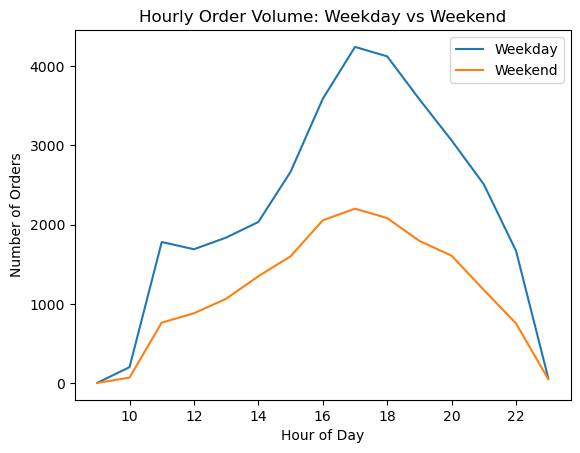

In [30]:
plt.figure()
orders_by_hour_daytype.plot(kind="line")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Orders")
plt.title("Hourly Order Volume: Weekday vs Weekend")
plt.show()

### Aggregate Daily Demand by Day Type

In [31]:
orders_by_date_daytype = (
    orders_2025
    .groupby(["order_date", "is_weekend"])["Order ID"]
    .nunique()
    .unstack(fill_value=0)
)

orders_by_date_daytype.head()

is_weekend,False,True
order_date,,
2025-01-01,163,0
2025-01-02,100,0
2025-01-03,165,0
2025-01-04,0,164
2025-01-05,0,163


### Visualize Daily Demand by Day Type

<Figure size 640x480 with 0 Axes>

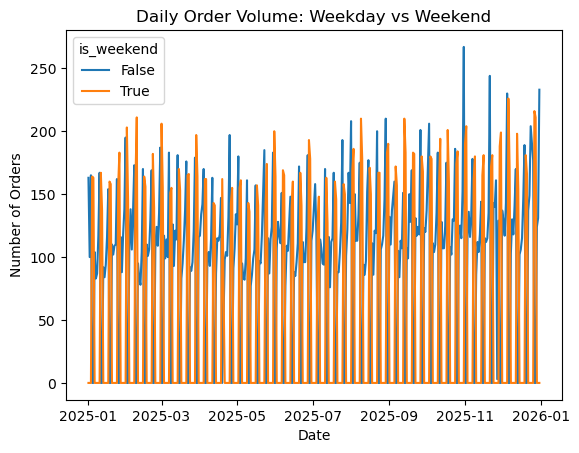

In [32]:
plt.figure()
orders_by_date_daytype.plot(kind="line")
plt.xlabel("Date")
plt.ylabel("Number of Orders")
plt.title("Daily Order Volume: Weekday vs Weekend")
plt.show()

### Smooth Daily Demand Using Weekly Averages

In [33]:
orders_by_date_daytype.index = pd.to_datetime(orders_by_date_daytype.index)
orders_by_date_daytype.index

DatetimeIndex(['2025-01-01', '2025-01-02', '2025-01-03', '2025-01-04',
               '2025-01-05', '2025-01-06', '2025-01-07', '2025-01-08',
               '2025-01-09', '2025-01-10',
               ...
               '2025-12-21', '2025-12-22', '2025-12-23', '2025-12-24',
               '2025-12-26', '2025-12-27', '2025-12-28', '2025-12-29',
               '2025-12-30', '2025-12-31'],
              dtype='datetime64[ns]', name='order_date', length=363, freq=None)

In [34]:
weekly_avg_by_daytype = (
    orders_by_date_daytype
    .resample("W")
    .mean()
)

weekly_avg_by_daytype.head()

is_weekend,False,True
order_date,,
2025-01-05,85.600000,65.400000
2025-01-12,79.714286,43.428571
2025-01-19,77.142857,45.428571
2025-01-26,84.714286,48.571429
2025-02-02,93.571429,49.714286


<Figure size 640x480 with 0 Axes>

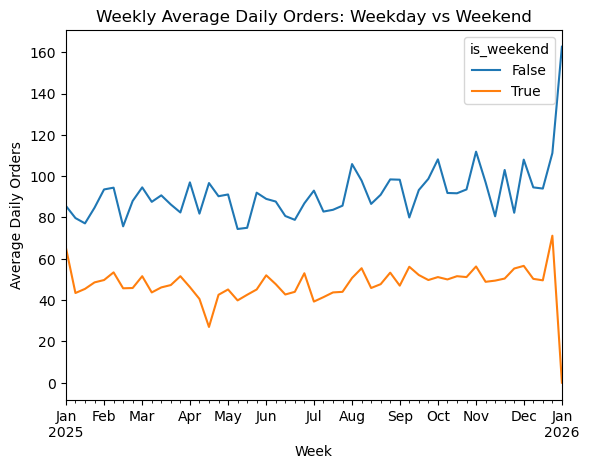

In [35]:
plt.figure()
weekly_avg_by_daytype.plot(kind="line")
plt.xlabel("Week")
plt.ylabel("Average Daily Orders")
plt.title("Weekly Average Daily Orders: Weekday vs Weekend")
plt.show()

### Interpretation: Weekly Average Daily Demand

Smoothing daily order volume to weekly averages reveals a clear and persistent
separation between weekday and weekend demand. Weekday demand consistently
exceeds weekend demand in average daily orders, reflecting the higher number
of weekdays per week and their contribution to baseline volume.

While weekend days exhibit higher per-day intensity, weekday demand provides
the dominant contribution to total weekly order volume. This distinction
highlights the importance of staffing for weekday consistency while preparing
for weekend demand spikes.

### Section 3 setup
- This section focuses on defining peak vs off-peak demand windows
- Using empirical hourly demand patterns from 2025 data.

### Establish Average Hourly Demand Profile


In [36]:
avg_orders_by_hour = orders_by_hour.copy()
avg_orders_by_hour

order_hour
9        5
10     270
11    2543
12    2570
13    2900
14    3381
15    4266
16    5641
17    6443
18    6205
19    5375
20    4669
21    3683
22    2422
23     114
Name: Order ID, dtype: int64

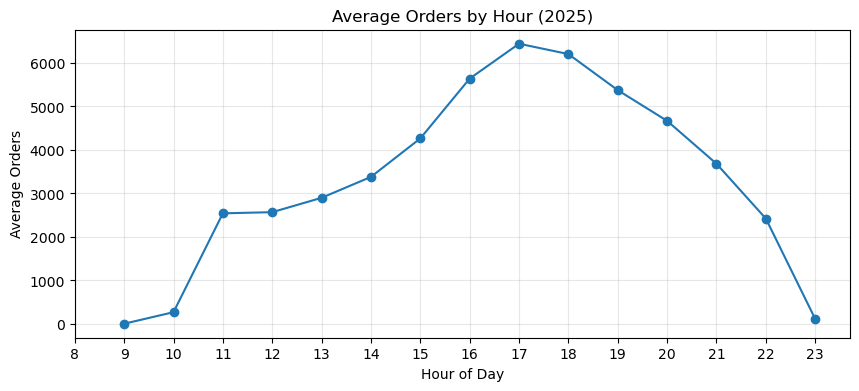

In [37]:
plt.figure(figsize=(10,4))
plt.plot(
    avg_orders_by_hour.index,
    avg_orders_by_hour.values,
    marker="o"
)
plt.title("Average Orders by Hour (2025)")
plt.xlabel("Hour of Day")
plt.ylabel("Average Orders")
plt.xticks(range(8, 24))
plt.grid(True, alpha=0.3)
plt.show()

### Define Peak Hour Threshold (Data-Driven)

In [38]:
peak_threshold = avg_orders_by_hour.quantile(0.75)
peak_threshold

5022.0

### Classify Hours as Peak vs Off-Peak

In [39]:
hour_classification = pd.DataFrame({
    "avg_orders": avg_orders_by_hour
})

hour_classification["is_peak_hour"] = (
    hour_classification["avg_orders"] >= peak_threshold
)

hour_classification

,avg_orders,is_peak_hour
order_hour,,
9,5,False
10,270,False
11,2543,False
12,2570,False
13,2900,False
14,3381,False
15,4266,False
16,5641,True
17,6443,True


### Attach Peak Classification to Order-Level Data

In [40]:
orders_with_peak_flag = orders_2025.copy()

orders_with_peak_flag["hour"] = (
    orders_with_peak_flag["Order Date"].dt.hour
)

orders_with_peak_flag = orders_with_peak_flag.merge(
    hour_classification["is_peak_hour"],
    left_on="hour",
    right_index=True,
    how="left"
)

orders_with_peak_flag.head()

,Order Date,Order ID,Order Type,Tax Amount,Tip,Discount,Order Total,Payments Total,Tender,order_hour,order_dow,order_date,is_weekend,hour,is_peak_hour
0,2025-03-31 22:54:00-07:00,QQBMWE3NMZQ0Y,Pick Up,2.09,0.00,0.0,25.99,25.99,Cash,22,Monday,2025-03-31,False,22,False
1,2025-03-31 22:35:00-07:00,TH041BMRDC2Y6,Delivery,0.00,0.00,0.0,25.13,0.00,NaN,22,Monday,2025-03-31,False,22,False
2,2025-03-31 22:33:00-07:00,06KJV691ZMV48,Pick Up,1.44,3.29,0.0,17.90,17.90,Debit Card,22,Monday,2025-03-31,False,22,False
3,2025-03-31 22:24:00-07:00,ASKA2CPN7GT2A,Pick Up,3.27,0.00,0.0,40.69,40.69,Cash,22,Monday,2025-03-31,False,22,False
4,2025-03-31 22:23:00-07:00,GK5Z5D128NA1M,Pick Up,1.61,0.92,0.0,20.05,20.05,Credit Card,22,Monday,2025-03-31,False,22,False


### Compare Peak vs Off-Peak Demand Volume

In [41]:
peak_vs_offpeak = (
    orders_with_peak_flag
    .groupby("is_peak_hour")
    .size()
    .rename(index={True: "Peak = 16-19", False: "Off-Peak = other"})
)

peak_vs_offpeak

is_peak_hour
Off-Peak = other    26823
Peak = 16-19        23664
dtype: int64

### Visualize Peak vs Off-Peak Split

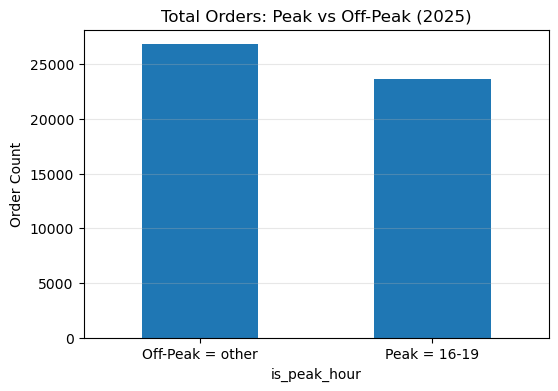

In [42]:
plt.figure(figsize=(6,4))
peak_vs_offpeak.plot(kind="bar")
plt.title("Total Orders: Peak vs Off-Peak (2025)")
plt.ylabel("Order Count")
plt.xticks(rotation=0)
plt.grid(axis="y", alpha=0.3)
plt.show()

### Weekday vs Weekend Peak Behavior


In [43]:
weekday_weekend_peak = (
    orders_with_peak_flag
    .groupby(["is_weekend", "is_peak_hour"])
    .size()
    .unstack()
)

weekday_weekend_peak

is_peak_hour,False,True
is_weekend,,
False,17511,15533
True,9312,8131


### Visualize Peak Behavior by Day Type

<Figure size 700x400 with 0 Axes>

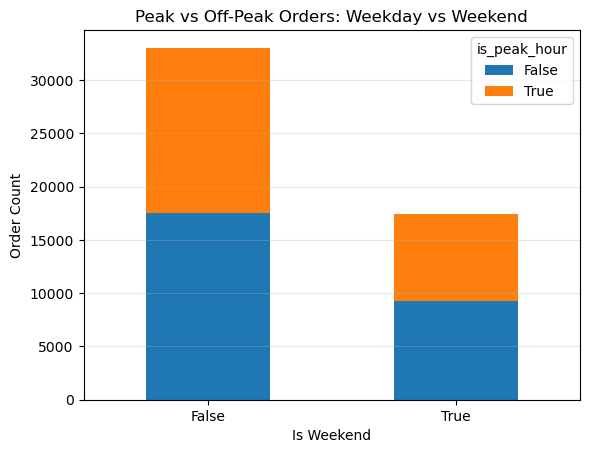

In [44]:
plt.figure(figsize=(7,4))
weekday_weekend_peak.plot(kind="bar", stacked=True)
plt.title("Peak vs Off-Peak Orders: Weekday vs Weekend")
plt.xlabel("Is Weekend")
plt.ylabel("Order Count")
plt.xticks(rotation=0)
plt.grid(axis="y", alpha=0.3)
plt.show()


### Section 3 Interpretation


Peak hours were defined empirically using the upper quartile of hourly demand.
Off-peak demand remains operationally significant and should be incorporated
into staffing, prep, and inventory planning. Weekend demand differs primarily
in distribution rather than timing, justifying separate operational treatment.

# Section 4: Staffing & Capacity Planning

- Convert observed demand patterns into operational staffing requirements.
- This section focuses on simple, explainable planning logic (no advanced forecasting).

### Select Daily Demand Series for Planning

In [45]:
demand_daily = orders_by_date.copy()

In [46]:
demand_daily_smoothed = (
    demand_daily
    .rolling(window=7, min_periods=1)
    .mean()
)

In [47]:
demand_daily.head(), demand_daily_smoothed.head()

(order_date
 2025-01-01    163
 2025-01-02    100
 2025-01-03    165
 2025-01-04    164
 2025-01-05    163
 Name: Order ID, dtype: int64,
 order_date
 2025-01-01    163.000000
 2025-01-02    131.500000
 2025-01-03    142.666667
 2025-01-04    148.000000
 2025-01-05    151.000000
 Name: Order ID, dtype: float64)

### Create Day-of-Week Baseline Demand Table

In [48]:
demand_daily_smoothed.index = pd.to_datetime(demand_daily_smoothed.index)

In [49]:
LOOKBACK_DAYS = 56
recent_demand = demand_daily_smoothed.tail(LOOKBACK_DAYS)

dow_baseline = (
    recent_demand
    .groupby(recent_demand.index.dayofweek)
    .mean()
    .rename(index={0:"Mon", 1:"Tue", 2:"Wed", 3:"Thu", 4:"Fri", 5:"Sat", 6:"Sun"})
    .to_frame("expected_orders")
)

dow_baseline

,expected_orders
order_date,
Mon,149.589286
Tue,149.714286
Wed,154.571429
Thu,148.244898
Fri,149.803571
Sat,150.125000
Sun,149.982143


### Generate Baseline Demand Forecast (Next 14 Days)


In [50]:
FORECAST_HORIZON_DAYS = 14

last_date = demand_daily_smoothed.index.max()
future_dates = pd.date_range(
    start=last_date + pd.Timedelta(days=1),
    periods=FORECAST_HORIZON_DAYS,
    freq="D"
)

dow_map = dow_baseline["expected_orders"].to_dict()

future_forecast_baseline = pd.Series(
    [dow_map[d.strftime("%a")] for d in future_dates],
    index=future_dates,
    name="forecast_orders_baseline"
)

future_forecast_baseline.head()


2026-01-01    148.244898
2026-01-02    149.803571
2026-01-03    150.125000
2026-01-04    149.982143
2026-01-05    149.589286
Freq: D, Name: forecast_orders_baseline, dtype: float64

### Plot Demand Context (History + Baseline Forecast)

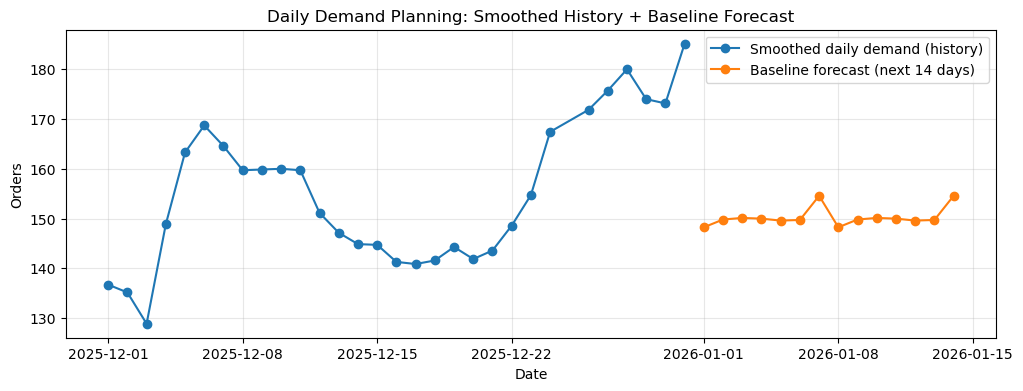

In [51]:
HISTORY_WINDOW = 30
history_series = demand_daily_smoothed.tail(HISTORY_WINDOW)

plt.figure(figsize=(12,4))
plt.plot(history_series.index, history_series.values, marker="o", label="Smoothed daily demand (history)")
plt.plot(future_forecast_baseline.index, future_forecast_baseline.values, marker="o", label="Baseline forecast (next 14 days)")
plt.title("Daily Demand Planning: Smoothed History + Baseline Forecast")
plt.xlabel("Date")
plt.ylabel("Orders")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

### Define Staffing Productivity Assumptions

In [52]:
# Explicit, tunable operational assumptions
ORDERS_PER_LABOR_HOUR = 12    # throughput
BUFFER_PCT = 0.10             # variability buffer
SHIFT_HOURS = 8               # standard shift length

### Convert Forecasted Orders to Labor Hours Needed

In [53]:
labor_hours_needed = (
    (future_forecast_baseline * (1 + BUFFER_PCT)) / ORDERS_PER_LABOR_HOUR
).rename("labor_hours_needed")

labor_hours_needed.head()

2026-01-01    13.589116
2026-01-02    13.731994
2026-01-03    13.761458
2026-01-04    13.748363
2026-01-05    13.712351
Freq: D, Name: labor_hours_needed, dtype: float64

### Convert Labor Hours to Estimated Headcount per Day


In [54]:
# Headcount is labor hours divided by shift length, rounded up
headcount_needed = (
    (labor_hours_needed / SHIFT_HOURS)
    .apply(lambda x: int(x) if x.is_integer() else int(x) + 1)
    .rename("headcount_needed")
)

headcount_needed.head()

2026-01-01    2
2026-01-02    2
2026-01-03    2
2026-01-04    2
2026-01-05    2
Freq: D, Name: headcount_needed, dtype: int64

### Determine Peak vs Off-Peak Labor Share

In [55]:
# Use empirical peak/off-peak split from Section 3
peak_share = peak_vs_offpeak.loc["Peak = 16-19"] / peak_vs_offpeak.sum()
offpeak_share = peak_vs_offpeak.loc["Off-Peak = other"] / peak_vs_offpeak.sum()

peak_share, offpeak_share

(0.4687147186404421, 0.5312852813595579)

### Allocate Labor Hours to Peak vs Off-Peak Periods

In [56]:
staffing_split = pd.DataFrame({
    "forecast_orders": future_forecast_baseline,
    "labor_hours_total": labor_hours_needed
})

staffing_split["labor_hours_peak"] = staffing_split["labor_hours_total"] * peak_share
staffing_split["labor_hours_offpeak"] = staffing_split["labor_hours_total"] * offpeak_share

staffing_split.head()

,forecast_orders,labor_hours_total,labor_hours_peak,labor_hours_offpeak
2026-01-01,148.244898,13.589116,6.369419,7.219697
2026-01-02,149.803571,13.731994,6.436388,7.295606
2026-01-03,150.125000,13.761458,6.450198,7.311260
2026-01-04,149.982143,13.748363,6.444060,7.304303
2026-01-05,149.589286,13.712351,6.427181,7.285170


### Build Daily Staffing Plan (Peak vs Off-Peak)

In [57]:
staffing_plan = staffing_split.copy()

staffing_plan["staff_peak"] = (
    staffing_plan["labor_hours_peak"] / SHIFT_HOURS
).apply(lambda x: int(x) if x.is_integer() else int(x) + 1)

staffing_plan["staff_offpeak"] = (
    staffing_plan["labor_hours_offpeak"] / SHIFT_HOURS
).apply(lambda x: int(x) if x.is_integer() else int(x) + 1)

staffing_plan["staff_total_est"] = (
    staffing_plan["staff_peak"] + staffing_plan["staff_offpeak"]
)

staffing_plan[[
    "forecast_orders",
    "labor_hours_total",
    "staff_peak",
    "staff_offpeak",
    "staff_total_est"
]]

,forecast_orders,labor_hours_total,staff_peak,staff_offpeak,staff_total_est
2026-01-01,148.244898,13.589116,1,1,2
2026-01-02,149.803571,13.731994,1,1,2
2026-01-03,150.125000,13.761458,1,1,2
2026-01-04,149.982143,13.748363,1,1,2
2026-01-05,149.589286,13.712351,1,1,2
2026-01-06,149.714286,13.723810,1,1,2
2026-01-07,154.571429,14.169048,1,1,2
2026-01-08,148.244898,13.589116,1,1,2
2026-01-09,149.803571,13.731994,1,1,2
2026-01-10,150.125000,13.761458,1,1,2


### Visualize Estimated Daily Headcount

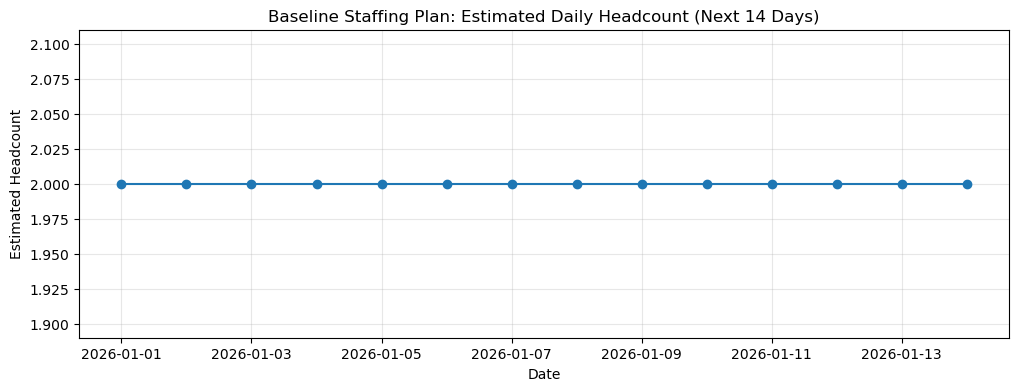

In [58]:
plt.figure(figsize=(12,4))
plt.plot(staffing_plan.index, staffing_plan["staff_total_est"], marker="o")
plt.title("Baseline Staffing Plan: Estimated Daily Headcount (Next 14 Days)")
plt.xlabel("Date")
plt.ylabel("Estimated Headcount")
plt.grid(True, alpha=0.3)
plt.show()

## Section 4 Interpretation


This section translates demand into staffing using simple, transparent assumptions.
A rolling average smooths volatility while preserving trend. Day-of-week baselines
provide a defensible short-term planning forecast. Labor hours are derived from
expected orders using throughput and buffer assumptions, then split into peak and
off-peak staffing using empirical demand patterns from Section 3.

# Section 5: Scenario Planning

Evaluate how staffing requirements change under different demand scenarios.

## Define Demand Scenarios

In [59]:
scenario_multipliers = {
    "Low (-10%)": 0.90,
    "Baseline": 1.00,
    "High (+20%)": 1.20
}

scenario_multipliers

{'Low (-10%)': 0.9, 'Baseline': 1.0, 'High (+20%)': 1.2}

## Generate Scenario-Based Demand Forecasts

In [60]:
scenario_forecasts = pd.DataFrame({
    name: future_forecast_baseline * multiplier
    for name, multiplier in scenario_multipliers.items()
})

scenario_forecasts.head()

,Low (-10%),Baseline,High (+20%)
2026-01-01,133.420408,148.244898,177.893878
2026-01-02,134.823214,149.803571,179.764286
2026-01-03,135.112500,150.125000,180.150000
2026-01-04,134.983929,149.982143,179.978571
2026-01-05,134.630357,149.589286,179.507143


## Convert Scenario Demand to Labor Hours

In [63]:
scenario_labor_hours = (
    (scenario_forecasts * (1 + BUFFER_PCT)) / ORDERS_PER_LABOR_HOUR
)

scenario_labor_hours.head()

,Low (-10%),Baseline,High (+20%)
2026-01-01,12.230204,13.589116,16.306939
2026-01-02,12.358795,13.731994,16.478393
2026-01-03,12.385313,13.761458,16.513750
2026-01-04,12.373527,13.748363,16.498036
2026-01-05,12.341116,13.712351,16.454821


## Convert Scenario Labor Hours to Headcount

In [64]:
scenario_headcount = (
    scenario_labor_hours / SHIFT_HOURS
).applymap(lambda x: int(x) if x.is_integer() else int(x) + 1)

scenario_headcount.head()

/var/folders/qv/xk2cf5916ygbcqf0lm73ntjc0000gn/T/ipykernel_7661/3066767638.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ).applymap(lambda x: int(x) if x.is_integer() else int(x) + 1)


,Low (-10%),Baseline,High (+20%)
2026-01-01,2,2,3
2026-01-02,2,2,3
2026-01-03,2,2,3
2026-01-04,2,2,3
2026-01-05,2,2,3


## Compare Daily Headcount Across Scenarios

In [65]:
scenario_headcount

,Low (-10%),Baseline,High (+20%)
2026-01-01,2,2,3
2026-01-02,2,2,3
2026-01-03,2,2,3
2026-01-04,2,2,3
2026-01-05,2,2,3
2026-01-06,2,2,3
2026-01-07,2,2,3
2026-01-08,2,2,3
2026-01-09,2,2,3
2026-01-10,2,2,3


## Visualize Headcount Sensitivity by Scenario

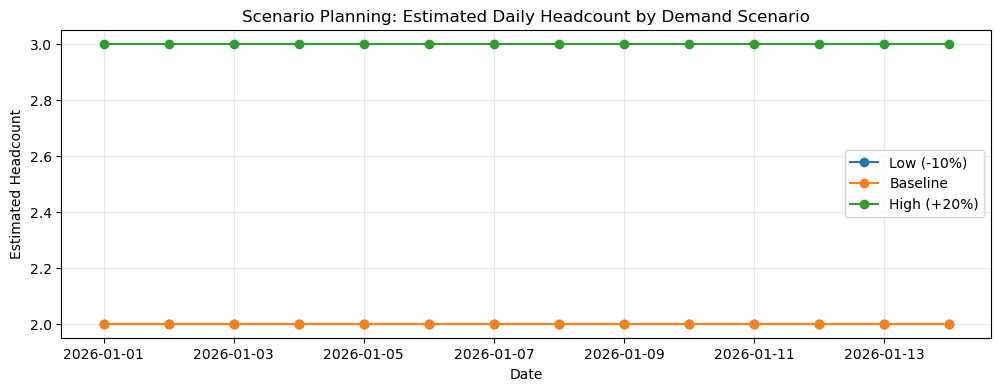

In [66]:
plt.figure(figsize=(12,4))

for scenario in scenario_headcount.columns:
    plt.plot(
        scenario_headcount.index,
        scenario_headcount[scenario],
        marker="o",
        label=scenario
    )

plt.title("Scenario Planning: Estimated Daily Headcount by Demand Scenario")
plt.xlabel("Date")
plt.ylabel("Estimated Headcount")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

## Identify Days with Staffing Risk

In [68]:
staffing_risk = pd.DataFrame({
    "baseline_staff": scenario_headcount["Baseline"],
    "high_demand_staff": scenario_headcount["High (+20%)"]
})

staffing_risk["additional_staff_needed"] = (
    staffing_risk["high_demand_staff"] - staffing_risk["baseline_staff"]
)

staffing_risk

,baseline_staff,high_demand_staff,additional_staff_needed
2026-01-01,2,3,1
2026-01-02,2,3,1
2026-01-03,2,3,1
2026-01-04,2,3,1
2026-01-05,2,3,1
2026-01-06,2,3,1
2026-01-07,2,3,1
2026-01-08,2,3,1
2026-01-09,2,3,1
2026-01-10,2,3,1


## Summary Statistics by Scenario

In [69]:
scenario_summary = scenario_headcount.describe().loc[["min", "mean", "max"]]
scenario_summary

,Low (-10%),Baseline,High (+20%)
min,2.0,2.0,3.0
mean,2.0,2.0,3.0
max,2.0,2.0,3.0


## Section 5 Interpretation

Scenario analysis shows that baseline staffing remains stable under moderate
demand variation. Even under a +20% demand scenario, headcount requirements
increase only on select days, indicating that current staffing levels are
generally robust. Operational risk is concentrated in high-demand scenarios,
suggesting that flexible staffing or on-call coverage is more effective than
permanent headcount increases.